# Import Libraries

In [9]:
import pandas as pd
import numpy as np

#Modelling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder

from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix, make_scorer, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from scipy.sparse import csr_matrix, hstack
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

#NLP
import nltk
import re

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.float_format = "{:,.2f}".format

RSEED = 42

import warnings
warnings.filterwarnings('ignore')

# Import Data

In [10]:
df = pd.read_csv('data/df_w_description.csv')

In [11]:
print(df.columns)
print(df.shape)
print(df.info())
print(df.head())

Index(['book_title', 'book_author', 'year_of_publication', 'publisher',
       'image_url_m', 'common_identifier', 'user_id', 'isbn', 'book_rating',
       'age', 'city', 'country', 'rating_count', 'description'],
      dtype='object')
(527, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527 entries, 0 to 526
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   book_title           527 non-null    object
 1   book_author          527 non-null    object
 2   year_of_publication  527 non-null    int64 
 3   publisher            527 non-null    object
 4   image_url_m          527 non-null    object
 5   common_identifier    527 non-null    int64 
 6   user_id              527 non-null    int64 
 7   isbn                 527 non-null    object
 8   book_rating          527 non-null    int64 
 9   age                  527 non-null    int64 
 10  city                 527 non-null    object
 11  country

# Descriptives

<Axes: title={'center': 'Word Count Distribution for book descriptions'}, ylabel='Frequency'>

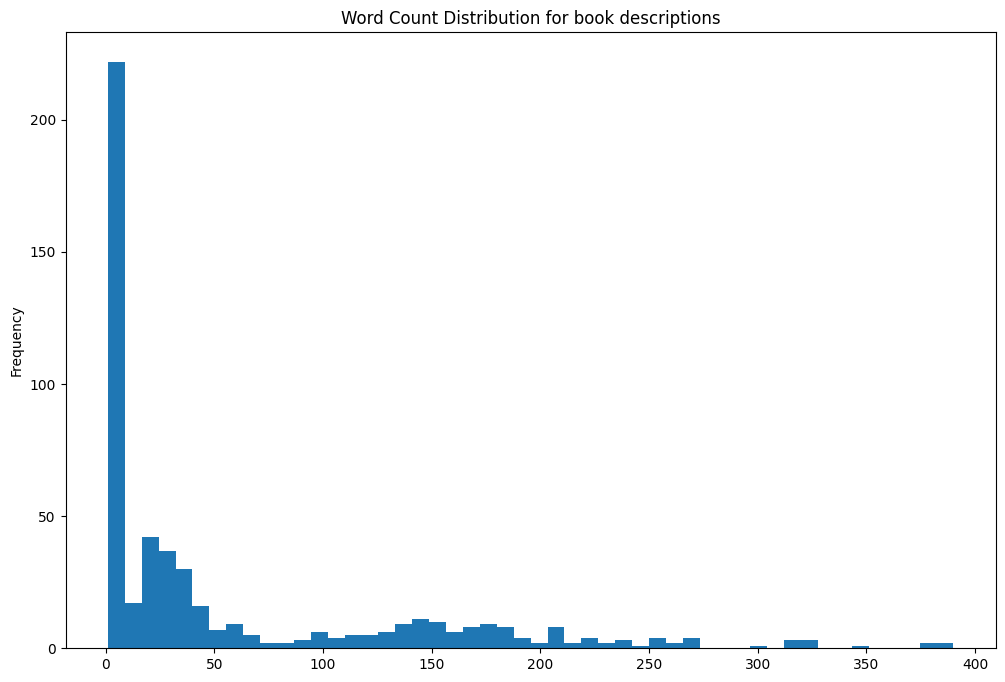

In [22]:
# Calculating the word count for book description
df['word_count'] = df['description'].apply(lambda x: len(str(x).split()))
# Plotting the word count
df['word_count'].plot(
    kind='hist',
    bins = 50,
    figsize = (12,8),title='Word Count Distribution for book descriptions')

# Content-based Filtering

In [7]:
# Preprocess the description column
df['description'] = df['description'].str.lower()  # Convert to lowercase
df['description'] = df['description'].str.replace('[^\w\s]', '')  # Remove punctuation
df['description'] = df['description'].str.replace('\d+', '')  # Remove numbers
df['description'] = df['description'].str.replace('\s+', ' ')  # Remove extra whitespaces

# Print the preprocessed description column
print(df['description'])


0         an absorbing narrative of winnie louie's life.
1                                    generic description
2      eddie dies on his eighty-third birthday in a t...
3      a novel about a symbologist who discovers the ...
4      don't miss little altars everywhere, the new y...
                             ...                        
522    british intelligence agent felicity "flick" cl...
523    "his name is connor ford and he falls like an ...
524    popular marriage counselor and seminar leader ...
525                                  generic description
526    "readers are in for the shock of kay scarpetta...
Name: description, Length: 527, dtype: object


In [35]:
# Create a TfidfVectorizer object with stop words beeing removed (i.e., 'and', 'the', 'of', etc.)
tfidf = TfidfVectorizer(stop_words='english', max_df=0.85, min_df=0.01, ngram_range=(1, 2))

# Fit and transform the description column of the dataframe
tfidf_matrix = tfidf.fit_transform(df['description'])

# Print the shape of the tfidf matrix
print(tfidf_matrix.shape)


(527, 6165)


In [37]:
# User input
user_input = "fantasy with knights and magic and dragons"

# Preprocess the user input
user_input = user_input.lower()
user_input = re.sub('[^\w\s]', '', user_input)
user_input = re.sub('\d+', '', user_input)
user_input = re.sub('\s+', ' ', user_input)

# Transform the user input using the tf-idf vectorizer
user_input_tfidf = tfidf.transform([user_input])

# Calculate the cosine similarity between the user input and the tf-idf matrix
cosine_sim = cosine_similarity(user_input_tfidf, tfidf_matrix)

# Get the indices of the top recommendations
top_indices = cosine_sim.argsort()[0][-5:][::-1]

# Get the top recommendations
top_recommendations = df.iloc[top_indices]

# Print the top recommendations
print(top_recommendations)


                                          book_title            book_author  \
55                                        Good Omens            Neil Gaiman   
250                              The Mists Of Avalon  Marion Zimmer Bradley   
38      Harry Potter And The Goblet Of Fire (Book 4)          J. K. Rowling   
444  The Amber Spyglass (His Dark Materials, Book 3)         Philip Pullman   
403     Face The Fire (Three Sisters Island Trilogy)           Nora Roberts   

     year_of_publication                      publisher  \
55                  1996                      Ace Books   
250                 1987                        Del Rey   
38                  2000                     Scholastic   
444                 2002  Knopf Books for Young Readers   
403                 2002                     Jove Books   

                                           image_url_m  common_identifier  \
55   http://images.amazon.com/images/P/0441003257.0...               1353   
250  http://imag

# Modelling

In [27]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, df['book_rating'], test_size=0.2, random_state=RSEED)

In [33]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train, y_train)

print(f"Mean accuracy of the model: {model.score(X_test, y_test)}")

Mean accuracy of the model: 0.2358490566037736


In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# Instantiate the Linear Regression model
regression_model = LinearRegression()
# Train the model
regression_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = regression_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")

Mean Squared Error: 6.261533839044696


# Predict Genres

In [44]:
from transformers import pipeline

# Create a text classification pipeline using the pretrained model
classifier = pipeline("text-classification", model="leireher/BookGenrePredictionDBERT")


ValueError: Could not load model leireher/BookGenrePredictionDBERT with any of the following classes: (<class 'transformers.models.auto.modeling_tf_auto.TFAutoModelForSequenceClassification'>, <class 'transformers.models.distilbert.modeling_tf_distilbert.TFDistilBertForSequenceClassification'>).

In [1]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="leireher/BookGenrePredictionDBERT")
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("leireher/BookGenrePredictionDBERT")
model = AutoModelForSequenceClassification.from_pretrained("leireher/BookGenrePredictionDBERT")

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [7]:
# Get genre classification for book recommendations
book_recommendations = df['book_title'].tolist()
genre_classification = classifier(book_recommendations)

# Print the genre classification
print(genre_classification)


NameError: name 'classifier' is not defined